### Import Libraries

In [63]:
# Import the necessary libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import pickle

from sklearn.metrics import mean_squared_error

from statsmodels.tsa.stattools import adfuller, ccf
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX

#import warnings
#warnings.simplefilter(action="ignore")

# Set all columns and rows to be displayed
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

### Import Data

In [2]:
# Import the dataset
data = pd.read_csv("../datasets/merged_df2.csv")

In [3]:
# Check the data
data.head()

,time,dengue_cases,denv_1,denv_2,denv_3,denv_4,Mean Temperature (°C),Mean Wind Speed (km/h),Daily Rainfall Total (mm),Maximum Temperature (°C),Max Wind Speed (km/h),Minimum Temperature (°C),google_trends
0,2018-04-08,38,0.000,0.505,0.484,0.011,28.528571,10.714286,0.742857,33.8,36.7,25.5,20
1,2018-04-15,56,0.000,0.505,0.484,0.011,28.914286,9.828571,2.057143,34.4,38.2,24.6,18
2,2018-04-22,55,0.000,0.505,0.484,0.011,28.142857,7.700000,0.371429,34.3,37.1,25.5,21
3,2018-04-29,74,0.000,0.505,0.484,0.011,28.414286,6.842857,4.800000,35.0,43.6,22.6,23
4,2018-05-06,62,0.029,0.549,0.382,0.039,28.785714,8.328571,3.742857,34.2,44.6,23.6,39


No catagorical values observed. However, due to the different types of numerical values being used, scaling will be required.

In [4]:
# Check the shape of the data
data.shape

(257, 13)

In [5]:
# Look at the datatypes
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 257 entries, 0 to 256
Data columns (total 13 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   time                       257 non-null    object 
 1   dengue_cases               257 non-null    int64  
 2   denv_1                     257 non-null    float64
 3   denv_2                     257 non-null    float64
 4   denv_3                     257 non-null    float64
 5   denv_4                     257 non-null    float64
 6   Mean Temperature (°C)      257 non-null    float64
 7   Mean Wind Speed (km/h)     257 non-null    float64
 8   Daily Rainfall Total (mm)  257 non-null    float64
 9   Maximum Temperature (°C)   257 non-null    float64
 10  Max Wind Speed (km/h)      257 non-null    float64
 11  Minimum Temperature (°C)   257 non-null    float64
 12  google_trends              257 non-null    int64  
dtypes: float64(10), int64(2), object(1)
memory usage: 

### Date Processing

The date feature is currently an object time. We will be converting it into a dateTime format.

In [6]:
# Convert the date column into dateTime format
data['time'] = pd.to_datetime(data['time'])

In [7]:
# Set the time as the index
data = data.set_index('time')

In [8]:
# Check the data 
data.head()

,dengue_cases,denv_1,denv_2,denv_3,denv_4,Mean Temperature (°C),Mean Wind Speed (km/h),Daily Rainfall Total (mm),Maximum Temperature (°C),Max Wind Speed (km/h),Minimum Temperature (°C),google_trends
time,,,,,,,,,,,,
2018-04-08,38,0.000,0.505,0.484,0.011,28.528571,10.714286,0.742857,33.8,36.7,25.5,20
2018-04-15,56,0.000,0.505,0.484,0.011,28.914286,9.828571,2.057143,34.4,38.2,24.6,18
2018-04-22,55,0.000,0.505,0.484,0.011,28.142857,7.700000,0.371429,34.3,37.1,25.5,21
2018-04-29,74,0.000,0.505,0.484,0.011,28.414286,6.842857,4.800000,35.0,43.6,22.6,23
2018-05-06,62,0.029,0.549,0.382,0.039,28.785714,8.328571,3.742857,34.2,44.6,23.6,39


### Train/Test Split

Given that this is a time series, we do a 30% train test split by time
* Train: ~75% of data - 2018 to 2021
* Test: ~25% of data - 2022 to 2023

In [9]:
# with 257 datapoints, the 195th data point is the end of 2018 and coincides with 75th percentile of datapoints by time
195/257

0.7587548638132295

In [10]:
# Train data will coveer 2018 to 2021
train = data.iloc[:195]

In [11]:
# Test data will cover 2022 to March 2023
test = data.iloc[195:]

In [12]:
train.shape

(195, 12)

In [13]:
test.shape

(62, 12)

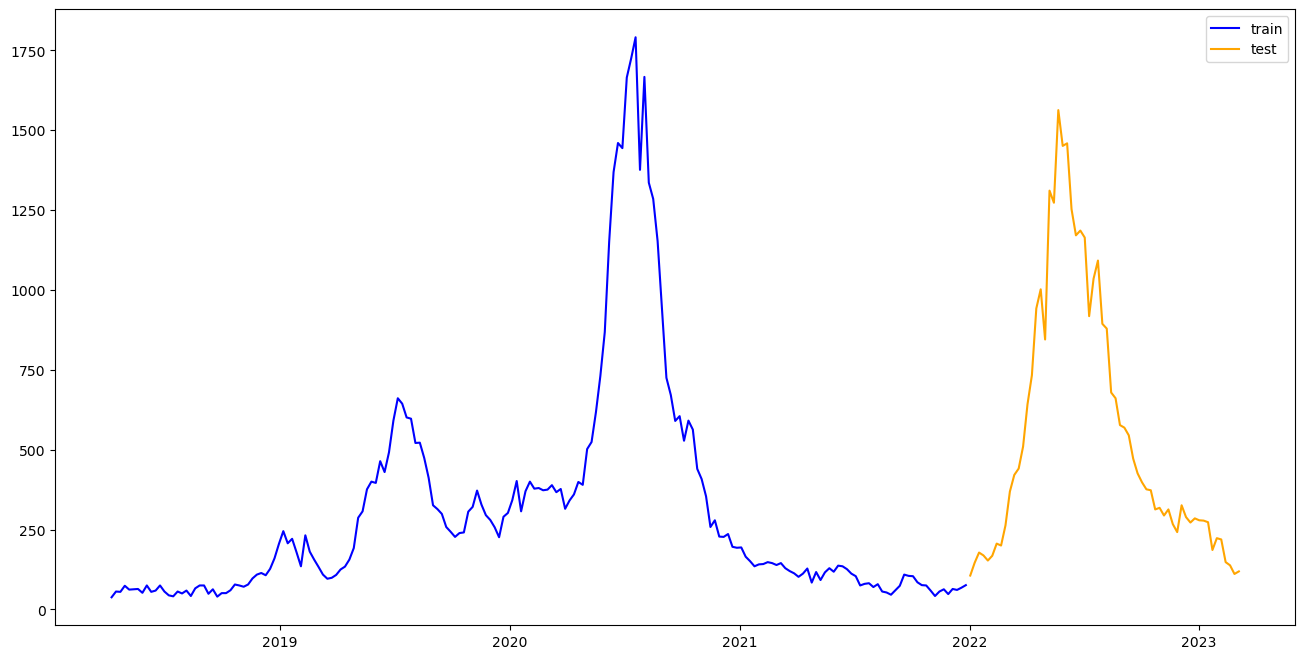

In [14]:
# Time series plot of the train and test data
def train_test_plot(train, test):
    plt.figure(figsize=(16, 8))
    
    plt.plot(train[['dengue_cases']], c='blue')
    plt.plot(test[['dengue_cases']], c='orange')
    
    plt.legend(['train', 'test'])
    
    plt.show()
    
train_test_plot(train, test)

### Stationarity Test

We will use the stationarity test to identify the $d$ parameter for the ARIMA model

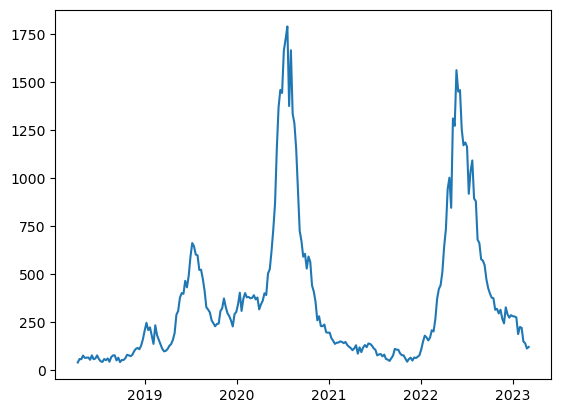

In [15]:
# Plot the data
plt.plot(data['dengue_cases']);

The time series of the dengue cases is clearly not stationary

In [16]:
# Instantiate a new dataframe for the difference information
diff = pd.DataFrame()

In [17]:
# Calculate the first difference of the dengue cases
diff['first_diff_dengue'] = data['dengue_cases'].diff()

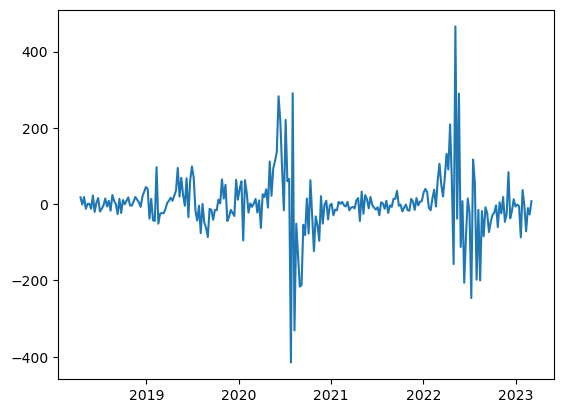

In [18]:
# Plot the first difference of the dengue cases
plt.plot(diff['first_diff_dengue']);

From the plot above, we can see that when the data is differenced once, the data is stationary. 

#### Augmented Dickey-Fuller Test

Let's also use the ADF test to test for stationarity, where the null hypothesis $H_0$ is that the data is not stationary

In [19]:
# Code written by Joseph Nelson.

def interpret_dftest(dftest):
    dfoutput = pd.Series(dftest[0:2], index=['Test Statistic','p-value'])
    return dfoutput

In [20]:
# Run the ADF test on the original dengue data
interpret_dftest(adfuller(data['dengue_cases']))

Test Statistic   -2.549748
p-value           0.103834
dtype: float64

The p-value is above 0.05, hence we cannot reject $H_0$, i.e. this data is not stationary.

In [21]:
# Run the ADF test on the differenced dengue data
interpret_dftest(adfuller(data['dengue_cases'].diff().dropna()))

Test Statistic   -5.242290
p-value           0.000007
dtype: float64

The p-value is below 0.05 and we can conclude that the once differenced data is stationary. This is also in line with the differenced data plot. Hence, we can set the $d$ value to $1$.

### Finding the $p$ and $q$ values

We can use a ACF and PACF plot to find the $p$ and $q$ values.

#### ACF and PACF Plot for $p$ value

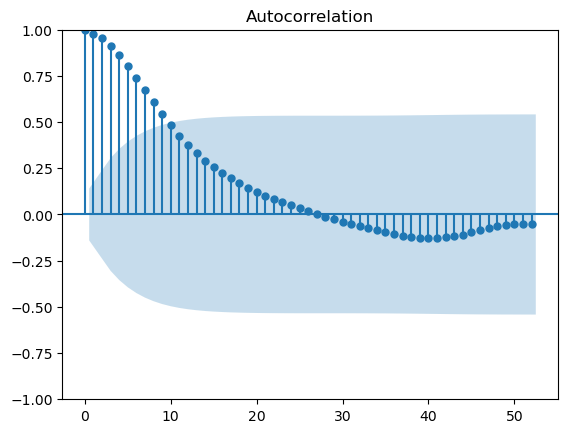

In [22]:
# Generate autocorrelation plot on training data.
plot_acf(train['dengue_cases'], lags = 52);

C:\ProgramData\Anaconda3\envs\dsi-sg\lib\site-packages\statsmodels\graphics\tsaplots.py:348: FutureWarning: The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.
  warnings.warn(


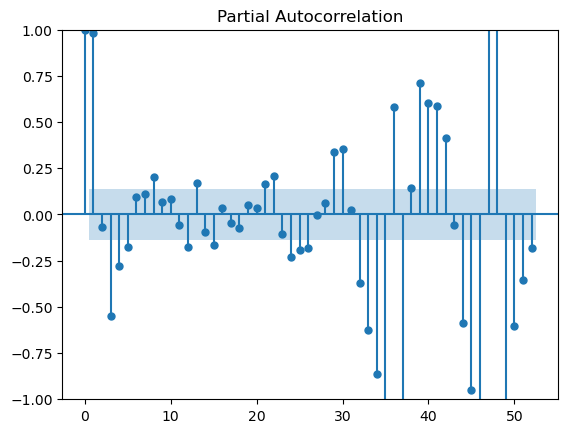

In [23]:
# Generate partial autocorrelation plot on training data.
plot_pacf(train['dengue_cases'], lags = 52);

In [64]:
train.columns

Index(['dengue_cases', 'denv_1', 'denv_2', 'denv_3', 'denv_4',
       'Mean Temperature (°C)', 'Mean Wind Speed (km/h)',
       'Daily Rainfall Total (mm)', 'Maximum Temperature (°C)',
       'Max Wind Speed (km/h)', 'Minimum Temperature (°C)', 'google_trends'],
      dtype='object')

In [122]:
# function to plot ccf
def plot_ccf(x, y, lags=None, ax=None):
    
    ccf_output = ccf(x[::-1], y[::-1], adjusted=False)
    
    #plt.stem(range(-len(ccf_output)//2, len(ccf_output)//2), ccf_output)
    if ax==None:
        plt.stem(range(len(ccf_output)), ccf_output)

        if lags == None:
            pass
        else:
            plt.xlim([0,lags])

        plt.ylim([-1,1])
        plt.xlabel('Lag')
        plt.ylabel('CCF')
        # 95% UCL / LCL
        plt.axhline(-1.96/np.sqrt(len(x)), color='k', ls='--') 
        plt.axhline(1.96/np.sqrt(len(x)), color='k', ls='--')

        plt.show()
    
    else:
        ax.stem(range(len(ccf_output)), ccf_output)

        if lags == None:
            pass
        else:
            ax.set_xlim([0,lags])

        ax.set_ylim([-1,1])
        ax.set_xlabel('Lag')
        ax.set_ylabel('CCF')
        # 95% UCL / LCL
        ax.axhline(-1.96/np.sqrt(len(x)), color='k', ls='--') 
        ax.axhline(1.96/np.sqrt(len(x)), color='k', ls='--')

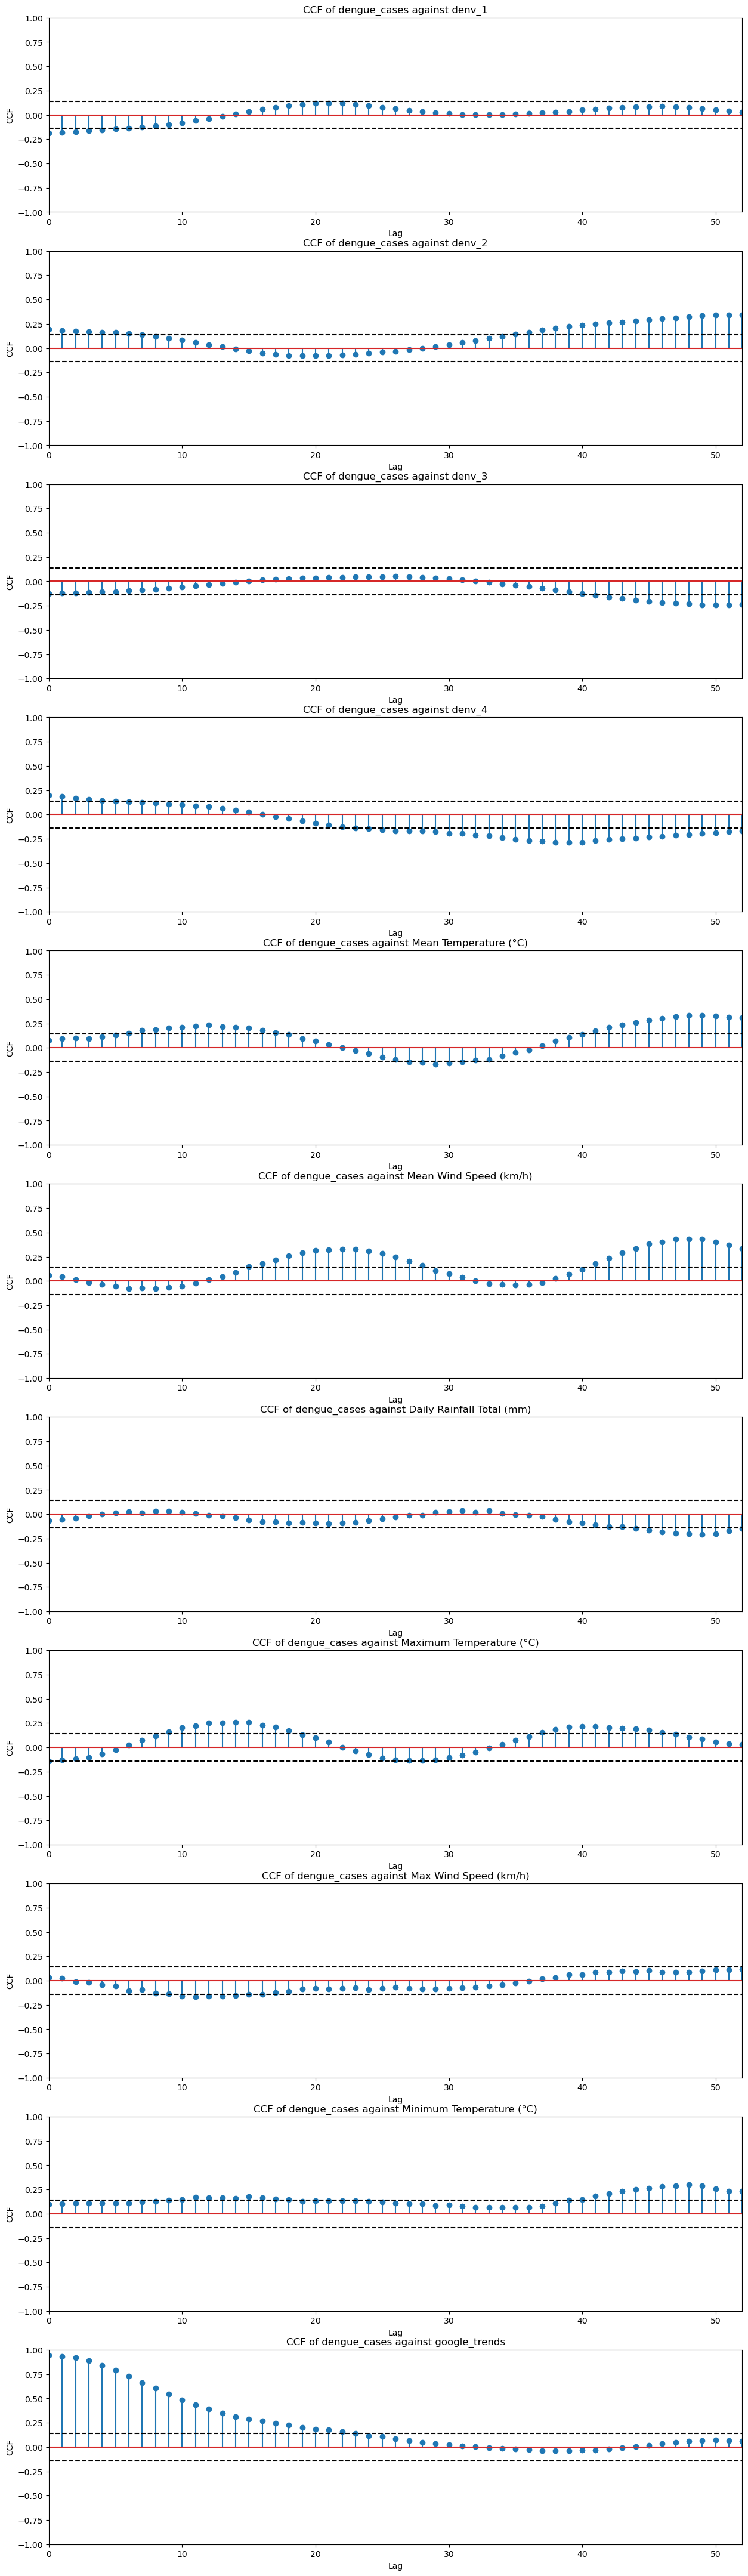

In [126]:
# Generate cross correlation between predictor variables and dengue cases
# do a plot for each of the variables
n_plots = len(train.columns)-1

fig, axes = plt.subplots(nrows=n_plots, figsize=(15,5*n_plots))

for i, x in enumerate(train.drop(columns='dengue_cases')):
    axes[i].set_title(f'CCF of dengue_cases against {x}')
    plot_ccf(train[x], train['dengue_cases'], lags=52, ax=axes[i])

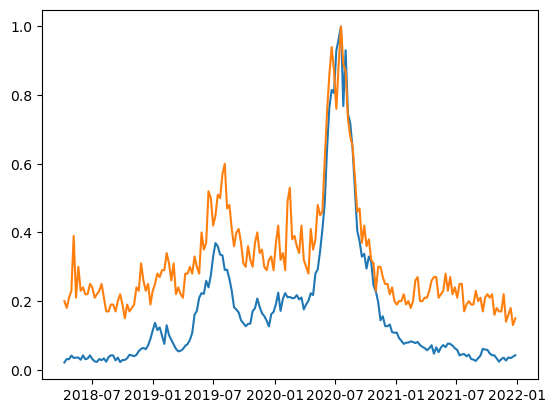

In [96]:
plt.plot(train['dengue_cases']/train['dengue_cases'].max())
plt.plot(train['google_trends']/train['google_trends'].max())

The first lag of the ACF plot is also positive. There is also a sharp cut off in the PACF plot after the second lag. Hence, we can take the next lag of the PACF as the $p$ value and set it to $3$. 

As the $AR$ and $MA$ terms might work against each other and we were able to identify the $p$ value, we will set the $q$ value as $0$.  

### ARIMA Model (3, 1, 0)

Next, we can fit the ARIMA model and run the prediction.

In [24]:
# Instantiate best model.
arima = ARIMA(endog=train['dengue_cases'], order=(3, 1, 0))

# Fit ARIMA model.
model = arima.fit()

# Generate predictions based on test set.
#preds = model.predict(start=test.index[0], end = test.index[-1])
# Start at 196 instead of 195 because we took difference = 1
preds = model.predict(start=196, end=257)

C:\ProgramData\Anaconda3\envs\dsi-sg\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency W-SUN will be used.
  self._init_dates(dates, freq)
C:\ProgramData\Anaconda3\envs\dsi-sg\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency W-SUN will be used.
  self._init_dates(dates, freq)
C:\ProgramData\Anaconda3\envs\dsi-sg\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency W-SUN will be used.
  self._init_dates(dates, freq)


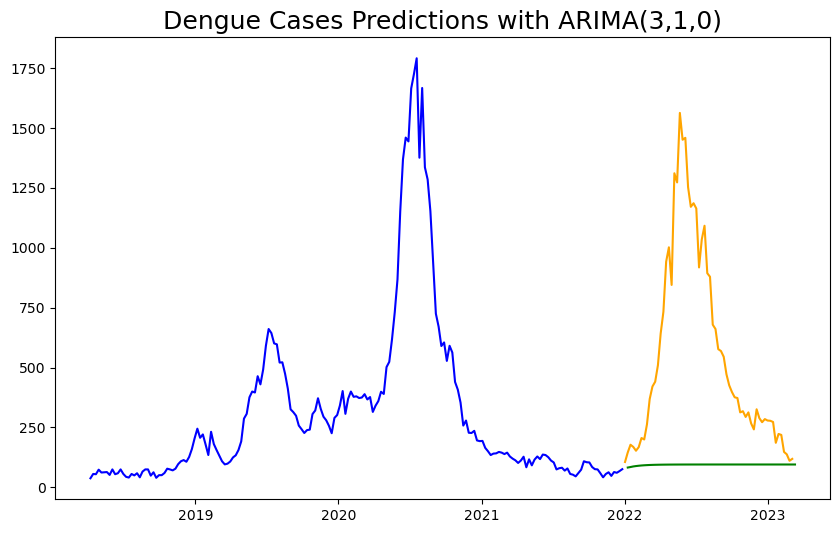

In [25]:
# Plot data.
plt.figure(figsize=(10,6))

# Plot training data in blue.
plt.plot(train['dengue_cases'], color = 'blue')

# Plot testing data in orange.
plt.plot(test['dengue_cases'], color = 'orange')

# Plot predicted values in green.
plt.plot(preds, color = 'green')

plt.title(label = 'Dengue Cases Predictions with ARIMA(3,1,0)', fontsize=18)
plt.show();

In [26]:
# Evaluate the predictions MSE
mean_squared_error(test['dengue_cases'], preds)

371980.9715666727

In [27]:
# Evaluate the predictions with mean error
mean_squared_error(test['dengue_cases'], preds, squared=False)

609.9024279068519

In [28]:
# Evaluation of the model
error = round(mean_squared_error(test['dengue_cases'], preds, squared=True), 0)
print(f'Minimum Dengue Cases: {round(data["dengue_cases"].min(),0)}')
print(f'Maximum Dengue Cases: {round(data["dengue_cases"].max(),0)}')

print(f'MSE relative to minimum values in dengue cases: {round(error / data["dengue_cases"].min(),0)}.')
print(f'MSE relative to maximum values in dengue cases: {round(error / data["dengue_cases"].max(),0)}.')

Minimum Dengue Cases: 38
Maximum Dengue Cases: 1791
MSE relative to minimum values in dengue cases: 9789.0.
MSE relative to maximum values in dengue cases: 208.0.


Looking at the MSE values as well as the ratio of the mean squared error to the minimum and maximum values in the dengue cases, we can see that the model is not very good. 

#### Residual Plot

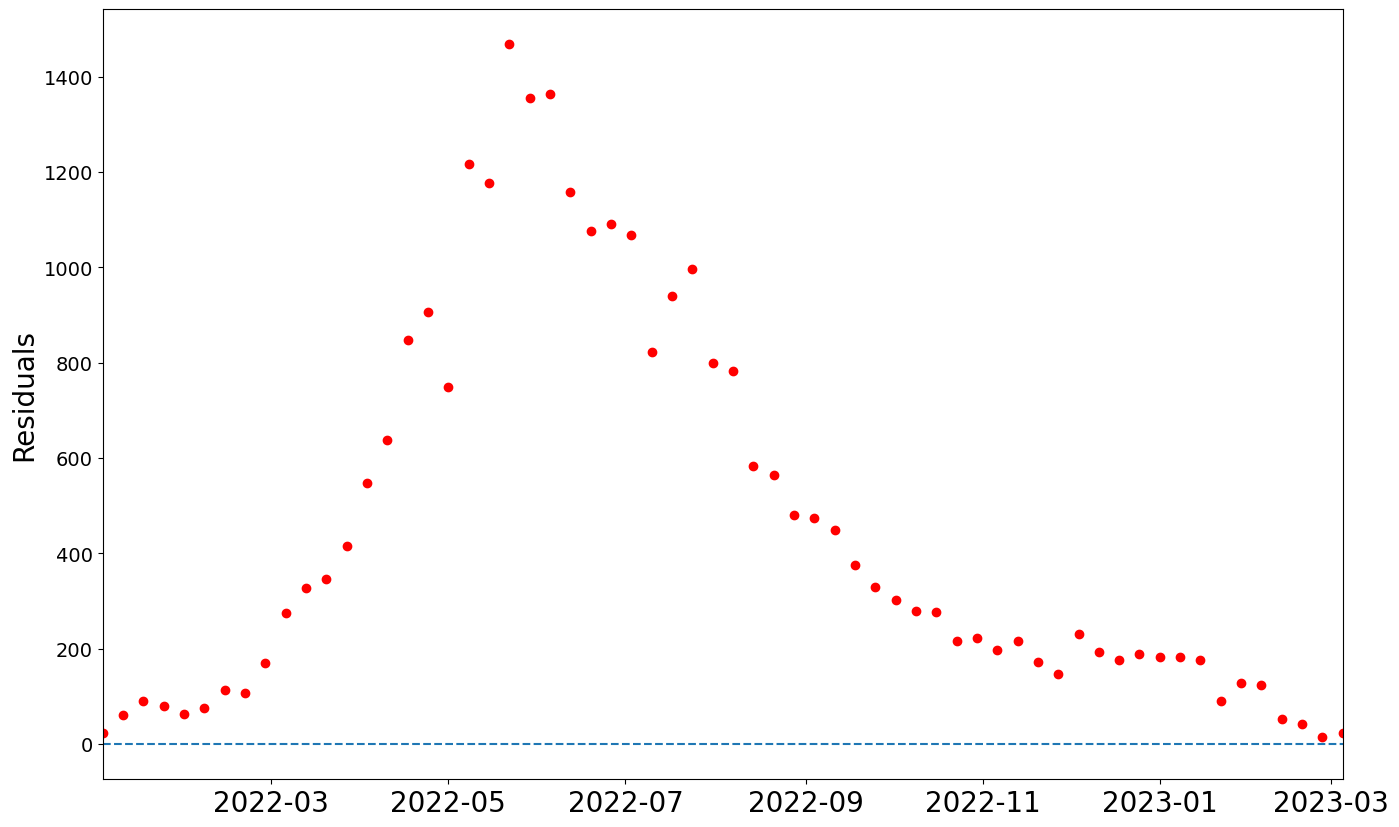

In [29]:
# Set figure size.
plt.figure(figsize=(16,10))

# Calculate residuals.
resids = test['dengue_cases'].values - preds.values

# Generate scatterplot of residuals.
plt.scatter(test['dengue_cases'].index, resids, c ='red')

# Plot baseline at y=0.
plt.hlines(y = 0,
           xmin = test['dengue_cases'].index.min(),
           xmax = test['dengue_cases'].index.max(),
           linestyles = '--')

# Set labels and axes.
plt.xticks(fontsize=20)
plt.xlim(test['dengue_cases'].index.min(), test['dengue_cases'].index.max())
plt.yticks(fontsize=14)
plt.ylabel('Residuals', fontsize = 20);

From the residual plot, we can see that the prediction is off to a high degree.

### ARIMAX Model

As we also have other features such as serology data, climate data and google trends, we can use an ARIMAX model to incorporate these features into the model. 

In [30]:
257-196 +1

62

In [31]:
# Instantiate best model.
arimax = ARIMA(endog=train['dengue_cases'], order=(3, 1, 0), 
               exog=train.drop(columns=['dengue_cases']))

# Fit ARIMA model.
model_2 = arimax.fit()

# Generate predictions based on test set.
#preds = model.predict(start=test.index[0], end = test.index[-1])
# Start at 196 instead of 195 because we took difference = 1
preds = model_2.predict(start=196, end=256, exog=test.drop(columns=['dengue_cases']))
# end should be 257, but it doesn't run unless i change it to 256 due to the shape of the exog

C:\ProgramData\Anaconda3\envs\dsi-sg\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency W-SUN will be used.
  self._init_dates(dates, freq)
C:\ProgramData\Anaconda3\envs\dsi-sg\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency W-SUN will be used.
  self._init_dates(dates, freq)
C:\ProgramData\Anaconda3\envs\dsi-sg\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency W-SUN will be used.
  self._init_dates(dates, freq)
C:\ProgramData\Anaconda3\envs\dsi-sg\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


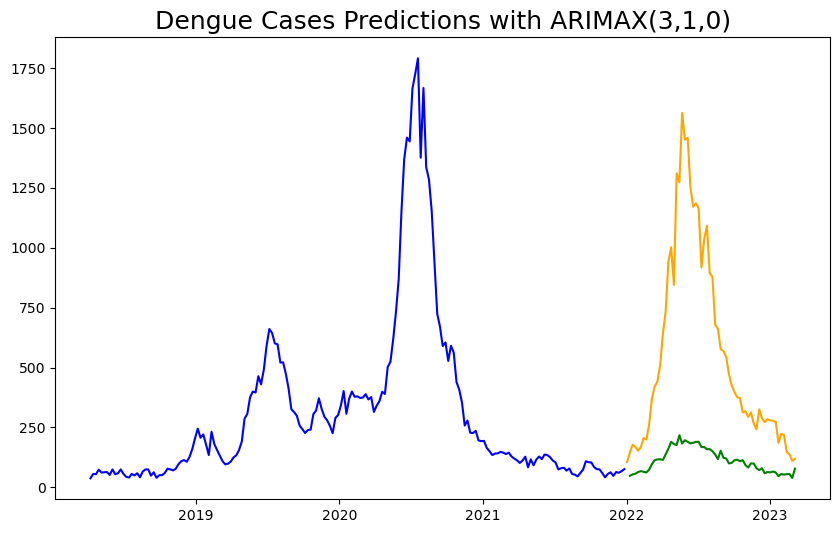

In [32]:
# Plot data.
plt.figure(figsize=(10,6))

# Plot training data in blue.
plt.plot(train['dengue_cases'], color = 'blue')

# Plot testing data in orange.
plt.plot(test['dengue_cases'], color = 'orange')

# Plot predicted values in green.
plt.plot(preds, color = 'green')

plt.title(label = 'Dengue Cases Predictions with ARIMAX(3,1,0)', fontsize=18)
plt.show();

### Feature Engineering

We'll restart the whole data processsing here to engineer new features.

In [33]:
# Import the dataset
data2 = pd.read_csv("../datasets/merged_df2.csv")

In [34]:
data2.head()

,time,dengue_cases,denv_1,denv_2,denv_3,denv_4,Mean Temperature (°C),Mean Wind Speed (km/h),Daily Rainfall Total (mm),Maximum Temperature (°C),Max Wind Speed (km/h),Minimum Temperature (°C),google_trends
0,2018-04-08,38,0.000,0.505,0.484,0.011,28.528571,10.714286,0.742857,33.8,36.7,25.5,20
1,2018-04-15,56,0.000,0.505,0.484,0.011,28.914286,9.828571,2.057143,34.4,38.2,24.6,18
2,2018-04-22,55,0.000,0.505,0.484,0.011,28.142857,7.700000,0.371429,34.3,37.1,25.5,21
3,2018-04-29,74,0.000,0.505,0.484,0.011,28.414286,6.842857,4.800000,35.0,43.6,22.6,23
4,2018-05-06,62,0.029,0.549,0.382,0.039,28.785714,8.328571,3.742857,34.2,44.6,23.6,39


Feature engineering<br>
1. No need to engineer the serology numbers as they are just the percentage of the current cases
2. No need to engineer the google-trends data as people search as they get infected
3. Try 7 and 14 days lag for the climate data

In [35]:
lag_features = ['Mean Temperature (°C)', 'Mean Wind Speed (km/h)', 
               'Daily Rainfall Total (mm)', 'Maximum Temperature (°C)', 
               'Max Wind Speed (km/h)', 'Minimum Temperature (°C)']

window1 = 7
window2 = 14

In [36]:
for feature in lag_features:
    data2[f"{feature}_lag{window1}"] = data2[feature].shift(window1)
    data2[f"{feature}_lag{window2}"] = data2[feature].shift(window2)

In [37]:
data2.dropna(inplace=True)

In [38]:
data2['time'] = pd.to_datetime(data2['time'])
data2 = data2.set_index('time')

In [39]:
data2.shape

(243, 24)

In [40]:
0.8 * 243

194.4

In [41]:
train2 = data2.iloc[:194]
test2 = data2.iloc[194:]

In [42]:
train2.shape

(194, 24)

In [43]:
test2.shape

(49, 24)

In [44]:
train2.head()

,dengue_cases,denv_1,denv_2,denv_3,denv_4,Mean Temperature (°C),Mean Wind Speed (km/h),Daily Rainfall Total (mm),Maximum Temperature (°C),Max Wind Speed (km/h),Minimum Temperature (°C),google_trends,Mean Temperature (°C)_lag7,Mean Temperature (°C)_lag14,Mean Wind Speed (km/h)_lag7,Mean Wind Speed (km/h)_lag14,Daily Rainfall Total (mm)_lag7,Daily Rainfall Total (mm)_lag14,Maximum Temperature (°C)_lag7,Maximum Temperature (°C)_lag14,Max Wind Speed (km/h)_lag7,Max Wind Speed (km/h)_lag14,Minimum Temperature (°C)_lag7,Minimum Temperature (°C)_lag14
time,,,,,,,,,,,,,,,,,,,,,,,,
2018-07-15,41,0.307,0.467,0.173,0.053,28.257143,10.285714,8.371429,32.3,51.1,21.9,22,28.314286,28.528571,6.914286,10.714286,6.914286,0.742857,33.1,33.8,49.3,36.7,24.0,25.5
2018-07-22,56,0.307,0.467,0.173,0.053,28.914286,11.514286,1.285714,31.9,40.0,23.5,23,27.842857,28.914286,5.600000,9.828571,17.371429,2.057143,32.9,34.4,45.0,38.2,22.9,24.6
2018-07-29,50,0.307,0.467,0.173,0.053,29.000000,12.400000,0.742857,33.0,41.0,24.9,25,29.728571,28.142857,9.557143,7.700000,0.600000,0.371429,33.4,34.3,36.4,37.1,24.2,25.5
2018-08-05,59,0.355,0.477,0.103,0.065,27.814286,10.028571,5.485714,32.4,40.3,24.0,21,29.100000,28.414286,9.328571,6.842857,1.685714,4.800000,33.1,35.0,42.5,43.6,23.6,22.6
2018-08-12,42,0.355,0.477,0.103,0.065,28.571429,10.342857,0.971429,33.0,40.0,21.9,17,27.742857,28.785714,8.271429,8.328571,4.628571,3.742857,32.2,34.2,47.2,44.6,23.6,23.6


In [45]:
exogenous_features = ['denv_1', 'denv_2', 'denv_3', 'denv_4', 
                     'Mean Temperature (°C)_lag7', 'Mean Temperature (°C)_lag14',
       'Mean Wind Speed (km/h)_lag7', 'Mean Wind Speed (km/h)_lag14',
       'Daily Rainfall Total (mm)_lag7', 'Daily Rainfall Total (mm)_lag14',
       'Maximum Temperature (°C)_lag7', 'Maximum Temperature (°C)_lag14',
       'Max Wind Speed (km/h)_lag7', 'Max Wind Speed (km/h)_lag14',
       'Minimum Temperature (°C)_lag7', 'Minimum Temperature (°C)_lag14', 'google_trends']

exogenous_features_7d = ['denv_1', 'denv_2', 'denv_3', 'denv_4', 
                     'Mean Temperature (°C)_lag7', 
       'Mean Wind Speed (km/h)_lag7', 
       'Daily Rainfall Total (mm)_lag7', 
       'Maximum Temperature (°C)_lag7', 
       'Max Wind Speed (km/h)_lag7', 
       'Minimum Temperature (°C)_lag7', 'google_trends']

exogenous_features_14d = ['denv_1', 'denv_2', 'denv_3', 'denv_4', 
                     'Mean Temperature (°C)_lag14', 
       'Mean Wind Speed (km/h)_lag14', 
       'Daily Rainfall Total (mm)_lag14', 
       'Maximum Temperature (°C)_lag14', 
       'Max Wind Speed (km/h)_lag14', 
       'Minimum Temperature (°C)_lag14', 'google_trends']

In [46]:
# Instantiate best model.
arimax = ARIMA(endog=train2['dengue_cases'], order=(3, 1, 0), 
               exog=train2[exogenous_features])

# Fit ARIMA model.
model_3 = arimax.fit()

# Generate predictions based on test set.
#preds = model.predict(start=test.index[0], end = test.index[-1])
# Start at 196 instead of 195 because we took difference = 1
preds3 = model_3.predict(start=194, end=242, exog=test2[exogenous_features])
# with exogenous_features, use start = 194 and end = 242

C:\ProgramData\Anaconda3\envs\dsi-sg\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency W-SUN will be used.
  self._init_dates(dates, freq)
C:\ProgramData\Anaconda3\envs\dsi-sg\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency W-SUN will be used.
  self._init_dates(dates, freq)
C:\ProgramData\Anaconda3\envs\dsi-sg\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency W-SUN will be used.
  self._init_dates(dates, freq)
C:\ProgramData\Anaconda3\envs\dsi-sg\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


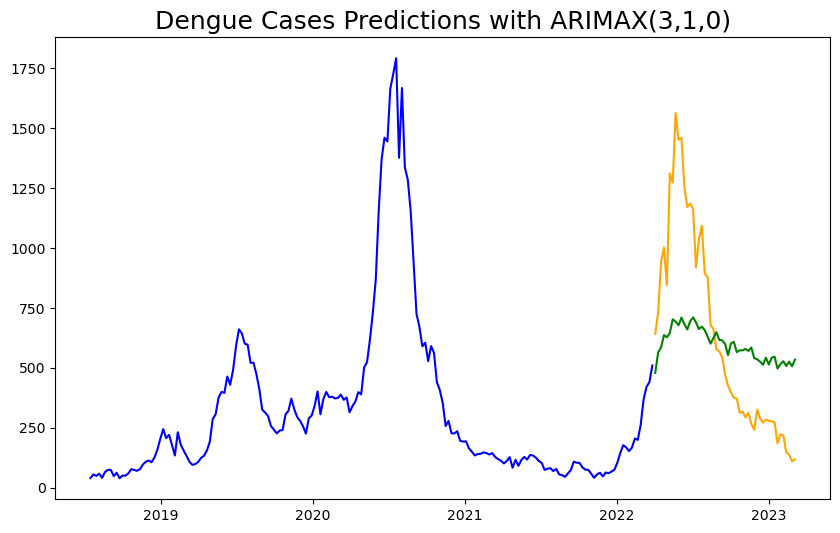

In [47]:
# Plot data.
plt.figure(figsize=(10,6))

# Plot training data in blue.
plt.plot(train2['dengue_cases'], color = 'blue')

# Plot testing data in orange.
plt.plot(test2['dengue_cases'], color = 'orange')

# Plot predicted values in green.
plt.plot(preds3, color = 'green')

plt.title(label = 'Dengue Cases Predictions with ARIMAX(3,1,0)', fontsize=18)
plt.show();

### Auto ARIMA

In [48]:
# Install pmdarine at your own risk. It casues a lot of issues with the dependencies. 
from pmdarima.arima import auto_arima

In [71]:
model_auto = auto_arima(train['dengue_cases'], exogenous=train.drop(columns=['dengue_cases']), 
                       trace=True, error_action='ignore', suppress_warnings=True)

Performing stepwise search to minimize aic
 ARIMA(2,0,2)(0,0,0)[0] intercept   : AIC=2191.907, Time=0.67 sec
 ARIMA(0,0,0)(0,0,0)[0] intercept   : AIC=2386.043, Time=0.04 sec
 ARIMA(1,0,0)(0,0,0)[0] intercept   : AIC=2209.764, Time=0.44 sec
 ARIMA(0,0,1)(0,0,0)[0] intercept   : AIC=2354.864, Time=0.50 sec
 ARIMA(0,0,0)(0,0,0)[0]             : AIC=2384.043, Time=0.18 sec
 ARIMA(1,0,2)(0,0,0)[0] intercept   : AIC=2203.947, Time=0.58 sec
 ARIMA(2,0,1)(0,0,0)[0] intercept   : AIC=2210.285, Time=0.64 sec
 ARIMA(3,0,2)(0,0,0)[0] intercept   : AIC=2187.115, Time=0.67 sec
 ARIMA(3,0,1)(0,0,0)[0] intercept   : AIC=2183.840, Time=0.62 sec
 ARIMA(3,0,0)(0,0,0)[0] intercept   : AIC=2193.794, Time=0.61 sec
 ARIMA(4,0,1)(0,0,0)[0] intercept   : AIC=2188.905, Time=0.66 sec
 ARIMA(2,0,0)(0,0,0)[0] intercept   : AIC=2212.126, Time=0.62 sec
 ARIMA(4,0,0)(0,0,0)[0] intercept   : AIC=inf, Time=0.59 sec
 ARIMA(4,0,2)(0,0,0)[0] intercept   : AIC=inf, Time=0.66 sec
 ARIMA(3,0,1)(0,0,0)[0]             : AIC=2

In [72]:
# Instantiate best model.
arimax = ARIMA(endog=train['dengue_cases'], order=(3, 0, 1), 
               exog=train.drop(columns=['dengue_cases']))

# Fit ARIMA model.
model_2 = arimax.fit()

# Generate predictions based on test set.
#preds = model.predict(start=test.index[0], end = test.index[-1])
# Start at 196 instead of 195 because we took difference = 1
#preds = model.predict(start=196, end=257)
preds_auto = model_2.predict(start=196, end=256, exog=test.drop(columns=['dengue_cases']))

C:\ProgramData\Anaconda3\envs\dsi-sg\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency W-SUN will be used.
  self._init_dates(dates, freq)
C:\ProgramData\Anaconda3\envs\dsi-sg\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency W-SUN will be used.
  self._init_dates(dates, freq)
C:\ProgramData\Anaconda3\envs\dsi-sg\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency W-SUN will be used.
  self._init_dates(dates, freq)
C:\ProgramData\Anaconda3\envs\dsi-sg\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


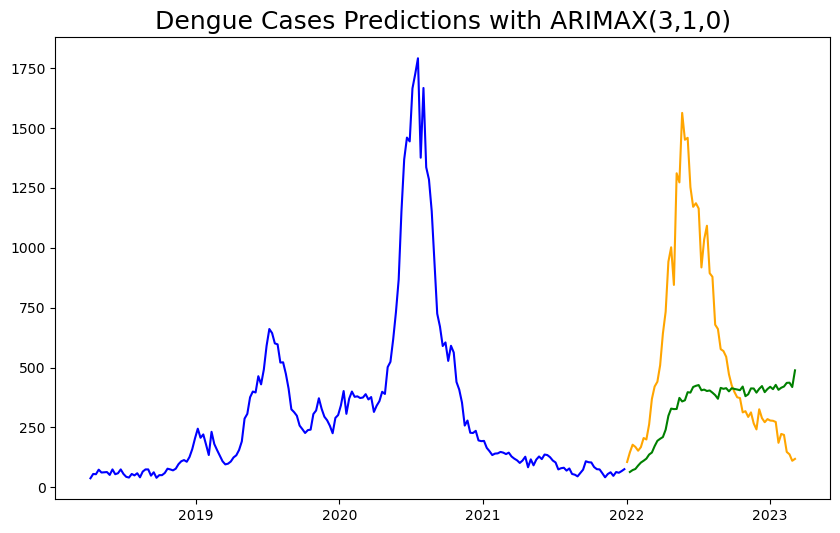

In [73]:
# Plot data.
plt.figure(figsize=(10,6))

# Plot training data in blue.
plt.plot(train['dengue_cases'], color = 'blue')

# Plot testing data in orange.
plt.plot(test['dengue_cases'], color = 'orange')

# Plot predicted values in green.
plt.plot(preds_auto, color = 'green')

plt.title(label = 'Dengue Cases Predictions with ARIMAX(3,1,0)', fontsize=18)
plt.show();

### SARIMAX Model

We note that there seem to be long term seasonality in the train data around annual level (lags of around 30, 40 and 50 weeks in PACF plot). 

Coefficients of PACF going beyong the range of -1 and 1 can also indicate that there is non-linear relationship triggered by other variables. Based on external research, the emergence of DENV-3 which the population has low herd immunity and weather conditions are contributing factors to the outbreak in 2020. These may be the variables that contributed to the non-linear autocorrelation. as such, we will need to include the x variables in the model for a better prediction and we will use SARIMAX only.

C:\ProgramData\Anaconda3\envs\dsi-sg\lib\site-packages\statsmodels\graphics\tsaplots.py:348: FutureWarning: The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.
  warnings.warn(


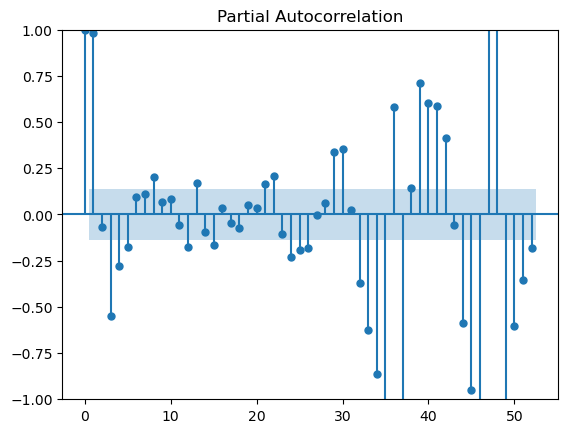

In [49]:
# Generate partial autocorrelation plot on training data.
plot_pacf(train['dengue_cases'], lags = 52);

In [62]:
model_sarimax = auto_arima(train2['dengue_cases'], exogenous=train2.drop(columns=['dengue_cases']), 
                           d=1, seasonal=True, m=29, max_P=5, max_Q=5, #max_order=52+5,
                           trace=True, error_action='ignore', suppress_warnings=True)

Performing stepwise search to minimize aic
 ARIMA(2,1,2)(1,0,1)[29] intercept   : AIC=2161.281, Time=14.96 sec
 ARIMA(0,1,0)(0,0,0)[29] intercept   : AIC=2180.794, Time=0.22 sec
 ARIMA(1,1,0)(1,0,0)[29] intercept   : AIC=2183.339, Time=8.69 sec
 ARIMA(0,1,1)(0,0,1)[29] intercept   : AIC=2183.562, Time=7.48 sec
 ARIMA(0,1,0)(0,0,0)[29]             : AIC=2178.910, Time=0.76 sec
 ARIMA(2,1,2)(0,0,1)[29] intercept   : AIC=2159.150, Time=9.33 sec
 ARIMA(2,1,2)(0,0,0)[29] intercept   : AIC=2158.322, Time=2.80 sec
 ARIMA(2,1,2)(1,0,0)[29] intercept   : AIC=2159.472, Time=7.86 sec
 ARIMA(1,1,2)(0,0,0)[29] intercept   : AIC=2157.263, Time=1.43 sec
 ARIMA(1,1,2)(1,0,0)[29] intercept   : AIC=2158.221, Time=5.50 sec
 ARIMA(1,1,2)(0,0,1)[29] intercept   : AIC=2158.346, Time=6.73 sec
 ARIMA(1,1,2)(1,0,1)[29] intercept   : AIC=2160.258, Time=9.52 sec
 ARIMA(0,1,2)(0,0,0)[29] intercept   : AIC=2173.523, Time=2.68 sec
 ARIMA(1,1,1)(0,0,0)[29] intercept   : AIC=2173.288, Time=2.62 sec
 ARIMA(1,1,3)(0,0,

In [50]:
# we pin down p,d,q and further tune the P, D, Q parameters
model_sarimax = auto_arima(train['dengue_cases'], exogenous=train.drop(columns=['dengue_cases']), 
                           start_p=1, max_p=1, start_q=2, max_q=2, d=1,
                           seasonal=True, m=52, max_P=52, max_Q=52, max_order=52,
                           trace=True, error_action='ignore', suppress_warnings=True)

Performing stepwise search to minimize aic
 ARIMA(1,1,2)(1,0,1)[52] intercept   : AIC=inf, Time=21.10 sec
 ARIMA(0,1,0)(0,0,0)[52] intercept   : AIC=2187.970, Time=0.08 sec
 ARIMA(1,1,0)(1,0,0)[52] intercept   : AIC=2191.290, Time=17.00 sec
 ARIMA(0,1,1)(0,0,1)[52] intercept   : AIC=2191.475, Time=7.52 sec
 ARIMA(0,1,0)(0,0,0)[52]             : AIC=2185.970, Time=0.20 sec
 ARIMA(0,1,0)(1,0,0)[52] intercept   : AIC=2189.693, Time=3.49 sec
 ARIMA(0,1,0)(0,0,1)[52] intercept   : AIC=2189.700, Time=6.00 sec
 ARIMA(0,1,0)(1,0,1)[52] intercept   : AIC=inf, Time=11.13 sec
 ARIMA(1,1,0)(0,0,0)[52] intercept   : AIC=2189.445, Time=1.09 sec
 ARIMA(0,1,1)(0,0,0)[52] intercept   : AIC=2189.673, Time=0.93 sec
 ARIMA(1,1,1)(0,0,0)[52] intercept   : AIC=2183.496, Time=1.21 sec
 ARIMA(1,1,1)(1,0,0)[52] intercept   : AIC=2184.601, Time=27.32 sec
 ARIMA(1,1,1)(0,0,1)[52] intercept   : AIC=2184.600, Time=19.80 sec
 ARIMA(1,1,1)(1,0,1)[52] intercept   : AIC=inf, Time=13.63 sec
 ARIMA(1,1,2)(0,0,0)[52] int

In [127]:
model = SARIMAX(endog=train['dengue_cases'], exog=train.drop(columns=['dengue_cases']),
                dates=train.index,
                order=(1,1,2),
                seasonal_order=(1,1,1,52),
                enforce_invertibility=False
               ).fit()

C:\ProgramData\Anaconda3\envs\dsi-sg\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency W-SUN will be used.
  self._init_dates(dates, freq)
C:\ProgramData\Anaconda3\envs\dsi-sg\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency W-SUN will be used.
  self._init_dates(dates, freq)
C:\ProgramData\Anaconda3\envs\dsi-sg\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'
C:\ProgramData\Anaconda3\envs\dsi-sg\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


In [128]:
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                      SARIMAX Results                                       
============================================================================================
Dep. Variable:                         dengue_cases   No. Observations:                  195
Model:             SARIMAX(1, 1, 2)x(1, 1, [1], 52)   Log Likelihood                -812.735
Date:                              Sat, 15 Apr 2023   AIC                           1659.470
Time:                                      10:12:20   BIC                           1709.719
Sample:                                  04-08-2018   HQIC                          1679.890
                                       - 12-26-2021                                         
Covariance Type:                                opg                                         
=============================================================================================
                                coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------------------
denv_1                    -2.069e+04   1.01e+04     -2.040      0.041   -4.06e+04    -815.040
denv_2                    -2.068e+04   1.02e+04     -2.028      0.043   -4.07e+04    -695.667
denv_3                    -2.026e+04   1.02e+04     -1.995      0.046   -4.02e+04    -358.664
denv_4                    -2.022e+04   1.01e+04     -2.000      0.045      -4e+04    -408.080
Mean Temperature (°C)        -2.8015     20.749     -0.135      0.893     -43.468      37.865
Mean Wind Speed (km/h)       -0.7160      5.470     -0.131      0.896     -11.438      10.005
Daily Rainfall Total (mm)    -0.5088      1.261     -0.403      0.687      -2.980       1.963
Maximum Temperature (°C)     -1.4726     12.412     -0.119      0.906     -25.800      22.854
Max Wind Speed (km/h)        -1.5147      0.826     -1.833      0.067      -3.134       0.105
Minimum Temperature (°C)     -0.7622      5.888     -0.129      0.897     -12.302      10.778
google_trends                 2.5140      1.020      2.464      0.014       0.515       4.513
ar.L1                         0.7040      0.120      5.843      0.000       0.468       0.940
ma.L1                        -0.8835      0.144     -6.122      0.000      -1.166      -0.601
ma.L2                         0.4304      0.076      5.684      0.000       0.282       0.579
ar.S.L52                     -0.2134      0.384     -0.556      0.578      -0.966       0.539
ma.S.L52                     -0.9547      7.408     -0.129      0.897     -15.473      13.564
sigma2                     3121.9791   2.22e+04      0.141      0.888   -4.04e+04    4.67e+04
===================================================================================
Ljung-Box (L1) (Q):                   0.00   Jarque-Bera (JB):               191.35
Prob(Q):                              0.96   Prob(JB):                         0.00
Heteroskedasticity (H):               0.62   Skew:                            -0.78
Prob(H) (two-sided):                  0.11   Kurtosis:                         8.47
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [131]:
preds_auto = model.predict(start=test.index[0], end=test.index[-1],
                           exog=test.drop(columns=['dengue_cases']))

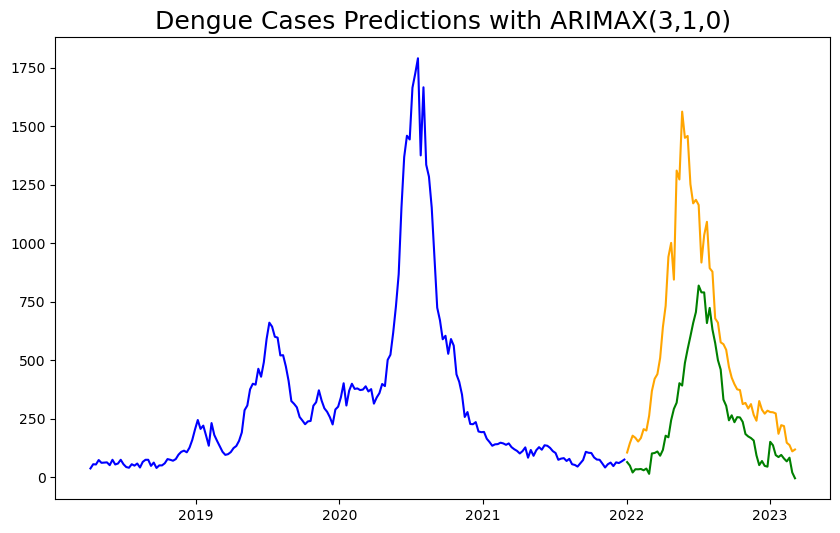

In [132]:
# Plot data.
plt.figure(figsize=(10,6))

# Plot training data in blue.
plt.plot(train['dengue_cases'], color = 'blue')

# Plot testing data in orange.
plt.plot(test['dengue_cases'], color = 'orange')

# Plot predicted values in green.
plt.plot(preds_auto, color = 'green')

plt.title(label = 'Dengue Cases Predictions with ARIMAX(3,1,0)', fontsize=18)
plt.show();